<a href="https://colab.research.google.com/github/souzapaulino/color-recognition/blob/develop/reconhecimento_cores_redes_neurais_convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Reconhecimento de cores com Redes Neurais Convolucionais
#### Deep Learning Book (www.deeplearningbook.com.br) Capítulo 47

## Introdução

Problema: Dada uma imagem, definir qual a cor pertence a classe especifica. 

Usaremos, portanto, uma abordagem de aprendizagem supervisionada, onde apresentaremos ao algoritmo diversas imagens, devidamente marcadas com suas cores e então treinaremos o algoritmo. Ao final do treinamento, teremos um modelo que poderá receber novas imagens (desta vez não marcadas previamente) e então o modelo deverá ser capaz de classificar qual a cor pertencente aquela classe.

Para essa tarefa, usaremos uma arquitetura de Rede Neural Convolucional. Essa arquitetura usa métodos de convolução para poder prever características específicas de uma imagem de acordo com o que aprende em um conjunto de treinamento.

## Definição dos Dados

Temoss os seguintes dados:

Conjunto de dados de treino:

Conjunto de dados de validação:

Conjunto de dados de teste:

Usamos os dados de treino para treinar o algoritmo e então criar o modelo preditivo. Usamos os dados de validação, para avaliar o modelo durante o treinamento. Usamos os dados de teste para validar a performance do modelo já treinado, ou seja, apresentamos ao modelo dados que ele não viu durante o treinamento, a fim de garantir que ele é capaz de fazer previsões.

## Carregando os Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Projeto_Alanne/
%ls dataset/teste

/content/drive/MyDrive/Projeto_Alanne
0/  12/  24/  36/  48/  60/


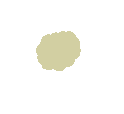

In [3]:
from IPython.display import Image
Image(filename = 'dataset/teste/0/A05.png')

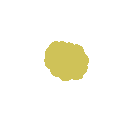

In [4]:
Image(filename = 'dataset/teste/24/A05.png')

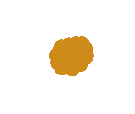

In [5]:
Image(filename = 'dataset/teste/60/A05.png')

### Pré-Processamento

Antes de realizar o treinamento é preciso fazer o pré-processamento nos dados, em nosso caso as imagens. Para essa tarefa, vamos usar a função ImageDataGenerator() do Keras e ajustar escala e zoom das imagens de treino e a escala das imagens de validação.

O pré-processamento dos dados é etapa crucial em qualquer projeto de Machine Learning e muitas técnicas podem ser usadas, sempre de acordo com os dados em mãos e o problema que estamos tentando resolver. Nos cursos da Data Science Academy ensinamos aos alunos uma variedade de técnicas.

In [6]:
# Criando os objetos train_datagen e validation_datagen com as regras de pré-processamento das imagens
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)


Aplicamos então os dois objetos criados anteriormente para pré-processar os dados de treino e de validação. Lembre-se: o tratamento aplicado aos dados de validação deve ser o mesmo tratamento aplicado aos dados de treino.

In [7]:
# Pré-processamento das imagens de treino e validação
training_set = train_datagen.flow_from_directory('dataset/trein',
                                                 target_size = (64, 64),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('dataset/valid',
                                                        target_size = (64, 64),
                                                        batch_size = 16,
                                                        class_mode = 'categorical')

Found 144 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


## Construindo a Rede Neural Convolucional

Nossa rede é uma sequência de camadas e podemos usar o modelo sequencial oferecido pelo Keras, que possui as funções necessárias para construir cada camada de uma rede neural convolucional.

O primeiro passo é carregar os pacotes necessários, o que é feito nas células abaixo.

O Keras utiliza o TensorFlow como backend, pois na prática o Keras é apenas uma biblioteca para simplificar a complexidade do TensorFlow. Aqui estão as versões utilizadas:

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Dense, Activation, Flatten, Dense, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [9]:
IMG_SHAPE = (64,64,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False

In [11]:
modelMobileNET = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(6, activation="softmax"),
    ]
)

In [12]:
modelMobileNET.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7

## Treinando a Rede Neural Convolucional

### Treinamento

Usaremos 8000 passos em nosso conjunto de treinamento para cada época. Escolhemos 2000 etapas de validação para as imagens de validação. 

*Adicionalmente:* O treinamento foi realizado considerando 1000 épocas mas com critério de parada antecipado caso a curva de aprendizagem alcance o platô (acurácia da validação com 30 épocas sem melhorar resultados)

In [13]:
base_learning_rate = 0.001
modelMobileNET.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=20, min_lr=0.1, verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=30,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

In [15]:
from keras.callbacks import ModelCheckpoint  
from datetime import datetime 

num_epochs = 1000
num_batch_size = 64

start = datetime.now()

history =  modelMobileNET.fit(training_set, batch_size=num_batch_size,epochs=num_epochs, validation_data=validation_set,
                     callbacks=[
                                EarlyStopping(patience=30, monitor="val_loss", verbose=1), reduce_lr
                                ])

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 72s 7s/step - loss: 0.6104 - accuracy: 0.2222 - val_loss: 0.4417 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.4408 - accuracy: 0.3403 - val_loss: 0.3888 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 3/1000
9/9 [==============================] - 1s 60ms/step - loss: 0.4187 - accuracy: 0.2847 - val_loss: 0.3941 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 4/1000
9/9 [==============================] - 1s 60ms/step - loss: 0.4025 - accuracy: 0.4514 - val_loss: 0.3725 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 5/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.3722 - accuracy: 0.4444 - val_loss: 0.3542 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 6/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.3724 - accuracy: 0.4583 - val_loss: 0.3392 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/1000
9/9 [==============================] - 1s 90ms/step - loss: 0.3533 - accuracy

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
print('Acurácia em treinamento: ', str(np.max(history.history['accuracy'])))  # Valor mais alto da acurácia no conjunto de treinamento

Acurácia em treinamento:  0.8541666865348816


In [19]:
print("Avaliação da acurácia geral na base de validação")
scores = modelMobileNET.evaluate(validation_set, verbose=0)
print("%s: %.2f%%" % (modelMobileNET.metrics_names[1], scores[1]*100))

Avaliação da acurácia geral na base de validação
accuracy: 77.78%


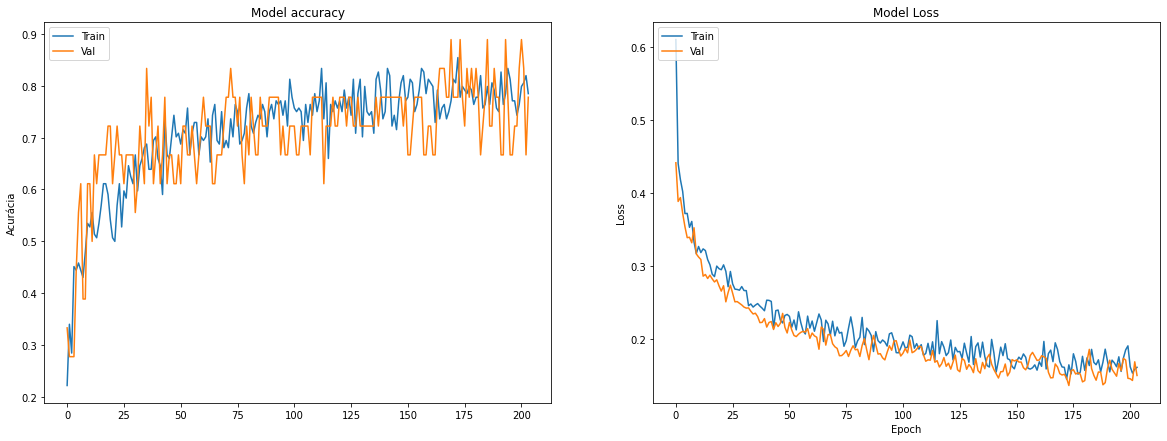

In [20]:
# Plot com valores de treinamento e validação
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acurácia')
plt.legend(['Train', 'Val'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


Após treinamento, o modelo treinado foi salvo em dois arquivos:

> arquivo no formato **.json** usado para carregar a rede neural convolucional \
> arquivo no formato **.h5** usado para carregar os pesos treinados da rede

In [24]:
# serialize model to JSON
model_json = modelMobileNET.to_json()
with open("./modelos/reconhecimento-cores.json", "w") as json_file:
    json_file.write(model_json)
## serialize weights to HDF5
modelMobileNET.save_weights("./modelos/reconhecimento-cores.h5")
print("Saved model to disk")

Saved model to disk


## Fazendo Previsões

O primeiro passo é carregar o dataset de testes da mesma forma que foram carregados os dadtasets de treinamento e validação. 

In [33]:
# Pré-processamento das imagens de testes
teste_set = train_datagen.flow_from_directory('dataset/teste',
                                                 target_size = (64, 64),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 18 images belonging to 6 classes.


Já que há 18 imagens na base de testes, uma para cada classe, então o processo de classificação deve ser automatizado. Assim será possível obter métricas de avaliação do modelo para todas as amostras (imagens) do dataset. Para isso, foi criada a função classificar_imagens_teste.

Após definir a função, a mesma é aplicada ao dataset de teste

In [107]:
def classificar_imagens_teste(diretorio_arquivos, datagen_de_teste):
  classificacao = []
  for i,j in zip(datagen_de_teste.filenames,datagen_de_teste.classes):
    img = mpimg.imread(str(diretorio_arquivos)+'/'+str(i))
    img = cv2.resize(img, (64,64))
    test_image = np.expand_dims(img, axis = 0)
    test_image = test_image[:,:,:,0:3]
    result = modelMobileNET.predict(test_image)
    classificacao.append(np.argmax(result))
  return classificacao

In [108]:
classificacao = classificar_imagens_teste('dataset/teste',teste_set)

Para avaliar o desempenho do modelo no dataset de testes, foi adotada como métrica geral a acurácia. Também foi plotada a matriz de confusão que mostra a relação entre o que é esperado e o que foi predito para cada classe.  

In [119]:
from sklearn.metrics import classification_report
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [117]:
print("Acurácia do modelo em TESTE: ", metrics.accuracy_score(teste_set.classes, classificacao)*100, "%")

Acurácia do modelo em TESTE:  83.33333333333334 %


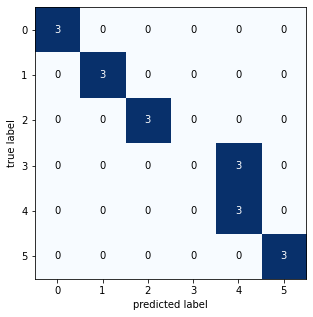

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(teste_set.classes, classificacao)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

Percebe-se, na matriz de confusão, que o modelo obteve ótimos resultados para todas classes, exceto para a classe 3, que corresponde ao rótulo 36mg/dL. 

Para esses casos é possível analisar as imagens indivisualmente e avaliar o comportamento do modelo em cada imagem. 

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [159]:
# Imagem 01 da classe '36mg/dL' 

img = mpimg.imread('dataset/teste/36/A05.png')
img = cv2.resize(img, (64,64))
test_image = np.expand_dims(img, axis = 0)
test_image = test_image[:,:,:,0:3]
result = modelMobileNET.predict(test_image)
classificacao = np.argmax(result)
if classificacao == 0:
  prediction = ' 0mg/dL'
elif classificacao == 1:
  prediction = '12mg/dL'
elif classificacao == 2:
  prediction = '24mg/dL'
elif classificacao == 3:
  prediction = '36mg/dL'
elif classificacao == 4:
  prediction = '48mg/dL'
elif classificacao == 5:
  prediction = '60mg/dL'
print('Classificação: '+str(prediction)+' - com '+str(np.round(result[0][classificacao]*100, decimals=2))+'% de acurácia')
print('valores obtidos para cada classe: '+str(np.round(result[0]*100)))

Classificação: 48mg/dL - com 59.61% de acurácia
valores obtidos para cada classe: [ 0.  0.  0. 40. 60.  1.]


In [160]:
# Imagem 02 da classe '36mg/dL' 
img = mpimg.imread('dataset/teste/36/A17.png')
img = cv2.resize(img, (64,64))
test_image = np.expand_dims(img, axis = 0)
test_image = test_image[:,:,:,0:3]
result = modelMobileNET.predict(test_image)
classificacao = np.argmax(result)
if classificacao == 0:
  prediction = ' 0mg/dL'
elif classificacao == 1:
  prediction = '12mg/dL'
elif classificacao == 2:
  prediction = '24mg/dL'
elif classificacao == 3:
  prediction = '36mg/dL'
elif classificacao == 4:
  prediction = '48mg/dL'
elif classificacao == 5:
  prediction = '60mg/dL'
print('Classificação: '+str(prediction)+' - com '+str(np.round(result[0][classificacao]*100, decimals=2))+'% de acurácia')
print('valores obtidos para cada classe: '+str(np.round(result[0]*100)))

Classificação: 48mg/dL - com 51.28% de acurácia
valores obtidos para cada classe: [ 0.  0.  0. 45. 51.  4.]


In [164]:
# Imagem 03 da classe '36mg/dL' 
import numpy as np
#from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

img = mpimg.imread('dataset/teste/36/A25.png')
img = cv2.resize(img, (64,64))
test_image = np.expand_dims(img, axis = 0)
test_image = test_image[:,:,:,0:3]
result = modelMobileNET.predict(test_image)
#classificacao = np.round(result, decimals=2)
classificacao = np.argmax(result)
if classificacao == 0:
  prediction = ' 0mg/dL'
elif classificacao == 1:
  prediction = '12mg/dL'
elif classificacao == 2:
  prediction = '24mg/dL'
elif classificacao == 3:
  prediction = '36mg/dL'
elif classificacao == 4:
  prediction = '48mg/dL'
elif classificacao == 5:
  prediction = '60mg/dL'
print('Classificação: '+str(prediction)+' - com '+str(np.round(result[0][classificacao]*100, decimals=2))+'% de acurácia')
print('valores obtidos para cada classe: '+str(np.round(result[0]*100)))

Classificação: 48mg/dL - com 52.32% de acurácia
valores obtidos para cada classe: [ 0.  0.  0. 47. 52.  1.]


**IMPRESSÕES FINAIS:**

Conforme observado nos resultados, o classificador obteve:

*   ótimo desempenho para caracterizar os padrões das classes 0 mg/dL, 12mg/dL, e 24mg/dL;
*   bons resultados nas classes 48mg/dL e 48mg/dL;
*   dificuldade para classificar imagens da classe 36mg/dL.
